In [ ]:
# FOR SCALE (SINGLE)

import cv2
import numpy as np
from collections import deque, Counter
import easyocr
import csv
import math
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
VALUE_SCALE  = 1.0
VALUE_OFFSET = 0.0

# =========================
# CSV Recorder
# =========================
class ValueRecorder:
    def __init__(self, csv_path="value_by_frame.csv"):
        self.csv_path = csv_path
        self.rows = []  # store dicts (we'll build header from union of keys)

    def add_single(self, frame, seconds, angle_deg, value):
        self.rows.append({
            'frame': frame,
            'seconds': seconds if seconds is not None else '',
            'angle_deg': angle_deg if angle_deg is not None else '',
            'value': value if value is not None else ''
        })

    def add_dual(self, frame, seconds, angle_deg, outer, inner):
        self.rows.append({
            'frame': frame,
            'seconds': seconds if seconds is not None else '',
            'angle_deg': angle_deg if angle_deg is not None else '',
            'outer': outer if outer is not None else '',
            'inner': inner if inner is not None else ''
        })

    def save(self):
        if not self.rows:
            return
        keys = set()
        for r in self.rows:
            keys.update(r.keys())
        ordered = []
        for k in ['frame', 'seconds']:
            if k in keys:
                ordered.append(k)
        for k in sorted(keys):
            if k not in ordered:
                ordered.append(k)

        with open(self.csv_path, 'w', newline='') as f:
            w = csv.DictWriter(f, fieldnames=ordered)
            w.writeheader()
            w.writerows(self.rows)
        print(f"[LOG] wrote {len(self.rows)} rows to {self.csv_path}")

# =========================
# Basic value/outlier filter
# =========================
class BasicValueFilter:
    """
    Rejects values that are outside [vmin, vmax] or that jump more than max_jump
    from the last accepted value. If hold_last=True, returns the last good value
    on rejection; otherwise returns None.
    """
    def __init__(self, vmin=None, vmax=None, max_jump=None, hold_last=True):
        self.vmin = vmin
        self.vmax = vmax
        self.max_jump = max_jump
        self.hold_last = hold_last
        self.prev = None  # last accepted value

    def __call__(self, v):
        # Reject NaNs / None
        if v is None or (isinstance(v, float) and (v != v)):
            return self.prev if self.hold_last else None

        # Range check
        if (self.vmin is not None and v < self.vmin) or (self.vmax is not None and v > self.vmax):
            return self.prev if self.hold_last else None

        # Step (jump) check
        if self.prev is not None and self.max_jump is not None:
            if abs(v - self.prev) > self.max_jump:
                return self.prev if self.hold_last else None

        # Accept
        self.prev = v
        return v

# =========================
# Circle Tracking
# =========================
class CircleMode:
    def __init__(self, maxlen=30, bin_size=3, min_samples=5,
                 max_center_diff=20, max_radius_diff=15):
        self.buffer = deque(maxlen=maxlen)
        self.bin_size = float(bin_size)
        self.min_samples = min_samples
        self.max_center_diff = max_center_diff
        self.max_radius_diff = max_radius_diff
        self.last = None

    def accept_circle(self, circle):
        if self.last is None:
            return True
        x, y, r = circle
        lx, ly, lr = self.last
        if abs(x - lx) > self.max_center_diff or abs(y - ly) > self.max_center_diff:
            return False
        if abs(r - lr) > self.max_radius_diff:
            return False
        return True

    def binned_mode(self, arr1d):
        bins = np.rint(arr1d / self.bin_size).astype(int)
        bid, count = Counter(bins.tolist()).most_common(1)[0]
        return bid * self.bin_size, count

    def update_circle(self, detected_circle):
        if detected_circle is not None:
            circle = tuple(map(float, detected_circle))
            if self.accept_circle(circle):
                self.buffer.append(circle)
                self.last = circle

        if len(self.buffer) < self.min_samples:
            return None

        arr = np.array(self.buffer)
        mx, _ = self.binned_mode(arr[:, 0])
        my, _ = self.binned_mode(arr[:, 1])
        mr, _ = self.binned_mode(arr[:, 2])
        return (mx, my, mr)


# =========================
# OCR
# =========================
reader = easyocr.Reader(['en'], gpu=False)

def detect_digits_easyocr(image, reader, min_conf=0.6):
    result = reader.readtext(image, detail=1, paragraph=False)
    digits, allowlist = [], "0123456789"
    for (bbox, text, prob) in result:
        if prob < min_conf:
            continue
        cleaned = ''.join(ch for ch in text if ch in allowlist)
        if cleaned == '':
            continue
        try:
            val_int = int(cleaned)
        except ValueError:
            continue
        xs, ys = zip(*bbox)
        cx_box, cy_box = int(sum(xs) / 4), int(sum(ys) / 4)
        digits.append({'center': (cx_box, cy_box),
                       'val': val_int, 'conf': float(prob)})
    return digits

def angle_deg_from_center(cx_box, cy_box, cx, cy):
    # image-coordinate angle: +x right, +θ clockwise, y down
    return float(np.degrees(np.arctan2(cy_box - cy, cx_box - cx)))

# =========================
# Unwrapping utilities 
# =========================
def wrap180(deg):
    return (np.asarray(deg, dtype=float) + 180.0) % 360.0 - 180.0

def unwrap_sorted_from_phase(thetas_deg, phi_deg, direction=+1):
    thetas = np.asarray(thetas_deg, dtype=float)
    shifted = wrap180(thetas - phi_deg)
    order = np.argsort(shifted)
    u_sorted = direction * np.rad2deg(np.unwrap(np.deg2rad(shifted[order])))
    u = np.empty_like(u_sorted)
    u[order] = u_sorted
    return u, float(u_sorted.min()), float(u_sorted.max())

# =========================
# Phase-optimized calibration 
# =========================
def fit_angle_to_value_phase_optimized(pairs,
                                       dedup_bin_deg=6.0,
                                       ransac_trim_frac=0.2,
                                       phi_step_coarse=5.0,
                                       phi_refine_halfwin=6.0,
                                       phi_step_refine=0.5, 
                                       value_max=None):
    if len(pairs) < 2:
        return None

    # Deduplicate by angle bins (keep highest-confidence per bin)
    by_bin = {}
    for p in pairs:
        b = int(np.rint(p['ang'] / dedup_bin_deg))
        if b not in by_bin or p.get('conf', 1.0) > by_bin[b].get('conf', 1.0):
            by_bin[b] = p
    P = list(by_bin.values())
    if len(P) < 2:
        return None

    thetas = np.array([p['ang'] for p in P], dtype=float)
    vals   = np.array([p['val'] for p in P], dtype=float)
    confs  = np.array([p.get('conf', 1.0) for p in P], dtype=float)
    W = np.diag(confs)

    def evaluate(phi_deg, direction):
        u, umin, umax = unwrap_sorted_from_phase(thetas, phi_deg, direction)
        A = np.vstack([u, np.ones_like(u)]).T
        a, b = np.linalg.lstsq(W @ A, W @ vals, rcond=None)[0]
        pred = a * u + b
        resid = vals - pred
        if 0.0 < ransac_trim_frac < 0.45 and len(vals) >= 5:
            kkeep = max(2, int(round((1.0 - ransac_trim_frac) * len(vals))))
            keep_idx = np.argsort(resid**2)[:kkeep]
            A_k = A[keep_idx]; vals_k = vals[keep_idx]; W_k = np.diag(confs[keep_idx])
            a, b = np.linalg.lstsq(W_k @ A_k, W_k @ vals_k, rcond=None)[0]
            pred = a * u + b
            resid = vals - pred
        ss_res = float(np.sum((resid) ** 2))
        ss_tot = float(np.sum((vals - vals.mean()) ** 2) + 1e-8)
        R2 = 1.0 - ss_res / ss_tot

        # uw = OnlineUnwrapper(phi_deg, direction, (umin, umax))
        def f_value(theta_deg):
            # u_live = uw.unwrap_one(theta_deg)
            # raw = a * u_live + b
            delta = direction * wrap180(theta_deg - phi_deg)
            raw = a * delta + b
            v = VALUE_SCALE * raw + VALUE_OFFSET

            if value_max is not None:
                if v > value_max:
                    v = v - value_max
                    
            return v

        return {
            'a': float(a), 'b': float(b), 'R2': float(R2),
            'dir': 'ccw' if direction > 0 else 'cw',
            'phi': float(phi_deg), 'span': (float(umin), float(umax)),
            'f': f_value
        }

    phis = np.arange(-180.0, 180.0, max(0.5, float(phi_step_coarse)))
    best = None
    for d in (+1, -1):
        for phi in phis:
            cand = evaluate(phi, d)
            if (best is None) or (cand['R2'] > best['R2']):
                best = cand

    phi0 = best['phi']; d0 = +1 if best['dir'] == 'ccw' else -1
    phis_ref = np.arange(phi0 - phi_refine_halfwin,
                         phi0 + phi_refine_halfwin + 1e-9,
                         max(0.1, float(phi_step_refine)))
    for phi in phis_ref:
        cand = evaluate(phi, d0)
        if cand['R2'] > best['R2']:
            best = cand

    print("[CAL] dir:", best['dir'], "phi:", f"{best['phi']:.2f}",
          "a:", f"{best['a']:.5f}", "b:", f"{best['b']:.3f}",
          "R2:", f"{best['R2']:.3f}", "span:", tuple(round(s,2) for s in best['span']))
    return best

# =========================
# Frame processing
# =========================
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)
    clahed = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(blurred)
    edges = cv2.Canny(clahed, 50, 150)

    # --- red mask (from your second script) ---
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    red1 = cv2.inRange(hsv, (0, 50, 50), (12, 255, 255))
    red2 = cv2.inRange(hsv, (168, 50, 50), (180, 255, 255))
    red_mask = cv2.medianBlur(cv2.bitwise_or(red1, red2), 5)

    return gray, blurred, edges, red_mask

def detect_circle(blurred):
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT,
                               dp=2, minDist=150, param1=120, param2=50,
                               minRadius=250, maxRadius=400)
    if circles is None:
        return None
    x, y, r = max(np.round(circles[0, :]).astype(int), key=lambda c: c[2])
    return (x, y, r)

# =========================
# Dual-scale helpers
# =========================
def split_digits_into_rings(digits, cx, cy):
    """
    Split OCR digits into outer vs inner rings using 1D k-means on radius.
    Returns (outer_digits, inner_digits).
    """
    if not digits:
        return [], []
    radii = np.array([math.hypot(d['center'][0]-cx, d['center'][1]-cy) for d in digits], dtype=float)
    if len(radii) < 2:
        return digits, []  # not enough to split; treat as outer

    # Initialize two centers (quartiles) and iterate a few times
    c0 = np.percentile(radii, 25); c1 = np.percentile(radii, 75)
    centers = np.array([c0, c1], dtype=float)
    for _ in range(10):
        labels = np.argmin(np.abs(radii[:, None] - centers[None, :]), axis=1)
        new0 = radii[labels == 0].mean() if np.any(labels == 0) else centers[0]
        new1 = radii[labels == 1].mean() if np.any(labels == 1) else centers[1]
        if abs(new0 - centers[0]) < 1e-3 and abs(new1 - centers[1]) < 1e-3:
            break
        centers = np.array([new0, new1], dtype=float)

    # Identify which label is outer (larger radius)
    outer_lbl = int(np.argmax(centers))
    outer, inner = [], []
    for d, lbl in zip(digits, labels):
        (outer if lbl == outer_lbl else inner).append(d)
    return outer, inner

# =========================
# Needle tracker 
# =========================
class NeedleTracker:
    def __init__(self,
                 window_deg=20.0,        # local search half-width
                 step_deg=1.0,           # coarse step
                 refine_half=3.0,        # refine window half-width
                 refine_step=0.2,        # refine step
                 hemi_margin=0.20,       # +20% stronger needed to consider opposite side
                 hemi_lock_frames=8,     # need N consecutive wins to actually switch
                 snr_gate=1.25,          # require at least this SNR between hemispheres
                 ema_alpha=0.45,         # 0..1; higher = less smoothing
                 darkness_w=0.35,        # weight for darkness term in score
                 inner_ratio=0.18,       # keep rays away from tick ring
                 outer_ratio=0.60,
                 red_w=2.0):             # weight for red-mask term
        self.prev = None
        self.window = float(window_deg)
        self.step = float(step_deg)
        self.refine_half = float(refine_half)
        self.refine_step = float(refine_step)
        self.hemi_margin = float(hemi_margin)
        self.hemi_lock_frames = int(hemi_lock_frames)
        self.snr_gate = float(snr_gate)
        self.alpha = float(ema_alpha)
        self.dark_w = float(darkness_w)
        self.inner_ratio = float(inner_ratio)
        self.outer_ratio = float(outer_ratio)
        self.red_w = float(red_w)

        self._hemi_win_count = 0  # consecutive wins for opposite hemisphere

    @staticmethod
    def _wrap180(a):
        return (a + 180.0) % 360.0 - 180.0

    @staticmethod
    def _angdiff(a, b):
        return abs((a - b + 180.0) % 360.0 - 180.0)

    def _ray_sums(self, gray, edges, red_mask, cx, cy, r, theta_deg):
        """Return (edge_sum, dark_sum, red_sum) along a ray at theta_deg."""
        h, w = gray.shape
        r1 = int(r * self.inner_ratio)
        r2 = int(r * self.outer_ratio)
        r2 = max(r2, r1 + 1)
        t = np.deg2rad(theta_deg)

        radii = np.linspace(r1 + 0.5, r2 - 0.5, num=max(1, r2 - r1 - 1))
        xs = cx + radii * np.cos(t)
        ys = cy + radii * np.sin(t)
        xi = np.clip(np.rint(xs).astype(int), 0, w - 1)
        yi = np.clip(np.rint(ys).astype(int), 0, h - 1)

        if red_mask is not None:
            red_ray = (red_mask[yi, xi] > 0).astype(np.uint8)
            edge_sum = float(np.sum(edges[yi, xi] * red_ray))  # edges restricted to red
            red_sum  = float(np.sum(red_ray))
        else:
            edge_sum = float(np.sum(edges[yi, xi]))
            red_sum  = 0.0

        dark_sum = float(np.sum(255 - gray[yi, xi]))  # if needle is dark
        return edge_sum, dark_sum, red_sum

    def _score(self, gray, edges, red_mask, cx, cy, r, theta_deg):
        """
        Anti-symmetric score: (ray at θ) - (ray at θ+180°),
        plus darkness and red-mask terms.
        """
        e1, d1, r1 = self._ray_sums(gray, edges, red_mask, cx, cy, r, theta_deg)
        e2, d2, r2 = self._ray_sums(gray, edges, red_mask, cx, cy, r, (theta_deg + 180.0) % 360.0)
        return (e1 - e2) + self.dark_w * (d1 - d2) + self.red_w * (r1 - r2)

    def _scan_peak(self, gray, edges, red_mask, cx, cy, r, start_deg, end_deg, step_deg):
        if end_deg < start_deg:
            start_deg, end_deg = end_deg, start_deg
        angles = np.arange(start_deg, end_deg + 1e-6, step_deg, dtype=float)
        scores = np.array(
            [self._score(gray, edges, red_mask, cx, cy, r, a) for a in angles],
            dtype=float
        )
        idx = int(np.argmax(scores))
        return float(angles[idx]), float(scores[idx])

    def _refine(self, gray, edges, red_mask, cx, cy, r, around_deg):
        a0 = around_deg
        a1, s1 = self._scan_peak(
            gray, edges, red_mask, cx, cy, r,
            a0 - self.refine_half, a0 + self.refine_half, self.refine_step
        )
        return a1, s1

    def measure(self, gray, edges, red_mask, cx, cy, r):
        # First frame: global scan
        if self.prev is None:
            a, s = self._scan_peak(gray, edges, red_mask, cx, cy, r, -180.0, 180.0, self.step)
            a, s = self._refine(gray, edges, red_mask, cx, cy, r, a)
            self.prev = a
            return a

        # Local around prev
        a1, s1 = self._scan_peak(
            gray, edges, red_mask, cx, cy, r,
            self.prev - self.window, self.prev + self.window, self.step
        )
        # Opposite hemisphere
        opp = self._wrap180(self.prev + 180.0)
        a2, s2 = self._scan_peak(
            gray, edges, red_mask, cx, cy, r,
            opp - self.window, opp + self.window, self.step
        )

        # Decide whether opposite hemisphere is truly better
        want_switch = (s2 > s1 * (1.0 + self.hemi_margin))
        snr = max(s1, s2) / (min(s1, s2) + 1e-6)
        if snr < self.snr_gate:
            want_switch = False

        # Consecutive wins required to actually switch hemisphere
        if want_switch:
            self._hemi_win_count += 1
        else:
            self._hemi_win_count = 0

        if self._hemi_win_count >= self.hemi_lock_frames:
            choice = a2
            self._hemi_win_count = 0
        else:
            choice = a1 if self._angdiff(a1, self.prev) <= self._angdiff(a2, self.prev) else a2

        # Refine and smooth (EMA on circle)
        best, _ = self._refine(gray, edges, red_mask, cx, cy, r, choice)
        diff = self._wrap180(best - self.prev)
        smoothed = self.prev + self.alpha * diff
        smoothed = self._wrap180(smoothed)

        self.prev = smoothed
        return smoothed

# =========================
# DRAW OVERLAY
# =========================
    
def draw_overlay(frame, sx, sy, sr, angle_deg, cal, gauge_mode,
                 value_single=None, value_outer=None, value_inner=None):
    # Circle + needle
    cv2.circle(frame, (sx, sy), sr, (255, 0, 0), 2)
    cv2.circle(frame, (sx, sy), 2, (0, 0, 255), 3)
    theta = np.deg2rad(angle_deg)
    r1, r2 = int(sr*0.1), int(sr*0.7)
    x1, y1 = int(sx + r1*np.cos(theta)), int(sy + r1*np.sin(theta))
    x2, y2 = int(sx + r2*np.cos(theta)), int(sy + r2*np.sin(theta))
    cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)

    # Value(s) — prefer provided (filtered) values; otherwise compute from cal
    y = 40
    if cal is not None:
        if gauge_mode == 'dual' and isinstance(cal, dict):
            if value_outer is None and cal.get('outer') is not None:
                value_outer = cal['outer']['f'](angle_deg)
            if value_inner is None and cal.get('inner') is not None:
                value_inner = cal['inner']['f'](angle_deg)

            if value_outer is not None:
                cv2.putText(frame, f"Outer: {value_outer:.2f}", (10, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                y += 28
            if value_inner is not None:
                cv2.putText(frame, f"Inner: {value_inner:.2f}", (10, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        else:
            if value_single is None:
                value_single = cal['f'](angle_deg)
            cv2.putText(frame, f"Value: {value_single:.2f}", (10, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)


# =========================
# Main
# =========================
def main(video_path,
         gauge_mode='single',     # 'single' or 'dual' 
         csv_out="value_by_frame.csv",
         show_window=True,
         ocr_period=5,
         value_max_single=None,
         value_max_outer=None,
         value_max_inner=None,
       
         value_min=None, value_max=None, max_jump=None,             # for single-scale
         outer_min=None, outer_max=None, outer_max_jump=None,       # for dual outer
         inner_min=None, inner_max=None, inner_max_jump=None,       # for dual inner
         hold_last=True):                                          
    """
    If gauge_mode='single': one calibration across all digits found.
    If gauge_mode='dual':   split digits by radius into outer/inner rings and calibrate both.
    CSV will include:
      single -> frame, seconds, angle_deg, value
      dual   -> frame, seconds, angle_deg, outer, inner
    """
    
    if value_max is None:
        value_max = value_max_single
    if outer_max is None:
        outer_max = value_max_outer
    if inner_max is None:
        inner_max = value_max_inner

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("Error: Could not open video.")

    # FPS for seconds conversion
    fps = cap.get(cv2.CAP_PROP_FPS)
    fps = fps if fps and fps > 1e-3 else None

    circle_mode = CircleMode()
    recorder = ValueRecorder(csv_out)

    # Instantiate basic filters
    if gauge_mode == 'dual':
        filt_outer = BasicValueFilter(vmin=outer_min, vmax=outer_max,
                                      max_jump=outer_max_jump, hold_last=hold_last)
        filt_inner = BasicValueFilter(vmin=inner_min, vmax=inner_max,
                                      max_jump=inner_max_jump, hold_last=hold_last)
    else:
        filt_single = BasicValueFilter(vmin=value_min, vmax=value_max,
                                       max_jump=max_jump, hold_last=hold_last)

    # Needle tracker (hemi lock + smoothing)
    needle_tracker = NeedleTracker(
        window_deg=18.0,
        step_deg=1.0,
        refine_half=3.0,
        refine_step=0.2,
        hemi_margin=0.25,
        ema_alpha=0.45,
        darkness_w=0.35,
        inner_ratio=0.5,
        outer_ratio=0.8
    )

    collected_all = []
    collected_outer, collected_inner = [], []
    cal = None  
    frame_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or read error.")
            break

        # seconds for this frame
        if fps is not None:
            seconds = frame_id / fps
        else:
            pos_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
            seconds = (pos_msec / 1000.0) if pos_msec else None

        gray, blurred, edges, red_mask = preprocess_frame(frame)
        stable = circle_mode.update_circle(detect_circle(blurred))

        angle_deg = None
        value_single = None
        value_outer = None
        value_inner = None

        if stable is not None:
            sx, sy, sr = map(int, stable)
            angle_deg = needle_tracker.measure(gray, edges, red_mask, sx, sy, sr)

            # OCR periodically while calibration is not ready
            if frame_id % ocr_period == 0 and (cal is None or (gauge_mode == 'dual' and (cal.get('outer') is None or cal.get('inner') is None))):
                digits = detect_digits_easyocr(blurred, reader)
                if digits:
                    if gauge_mode == 'dual':
                        outer_digits, inner_digits = split_digits_into_rings(digits, sx, sy)

                        def to_pairs(dlist):
                            pairs = []
                            for d in dlist:
                                cx_box, cy_box = d['center']
                                ang = angle_deg_from_center(cx_box, cy_box, sx, sy)
                                pairs.append({'ang': ang, 'val': d['val'], 'conf': d['conf']})
                            return pairs

                        collected_outer.extend(to_pairs(outer_digits))
                        collected_inner.extend(to_pairs(inner_digits))

                        if len(collected_outer) >= 3 and (cal is None or cal.get('outer') is None):
                            cal_out = fit_angle_to_value_phase_optimized(collected_outer, value_max=value_max_outer)
                        else:
                            cal_out = cal.get('outer') if isinstance(cal, dict) else None

                        if len(collected_inner) >= 3 and (cal is None or cal.get('inner') is None):
                            cal_in = fit_angle_to_value_phase_optimized(collected_inner, value_max=value_max_inner)
                        else:
                            cal_in = cal.get('inner') if isinstance(cal, dict) else None

                        cal = {'outer': cal_out, 'inner': cal_in}

                    else:  # single scale
                        for d in digits:
                            cx_box, cy_box = d['center']
                            ang = angle_deg_from_center(cx_box, cy_box, sx, sy)
                            collected_all.append({'ang': ang, 'val': d['val'], 'conf': d['conf']})
                        if len(collected_all) >= 3 and cal is None:
                            cal = fit_angle_to_value_phase_optimized(collected_all, value_max=value_max_single)

            # Compute value(s) and pass through filters
            if cal is not None:
                if gauge_mode == 'dual' and isinstance(cal, dict):
                    if cal.get('outer') is not None:
                        value_outer_raw = cal['outer']['f'](angle_deg)
                        value_outer = filt_outer(value_outer_raw)
                    if cal.get('inner') is not None:
                        value_inner_raw = cal['inner']['f'](angle_deg)
                        value_inner = filt_inner(value_inner_raw)
                else:
                    value_single_raw = cal['f'](angle_deg)
                    value_single = filt_single(value_single_raw)

            # Draw overlay 
            if show_window and stable is not None:
                draw_overlay(frame, sx, sy, sr, angle_deg, cal, gauge_mode,
                             value_single=value_single, value_outer=value_outer, value_inner=value_inner)

        # Log per frame
        if gauge_mode == 'dual':
            recorder.add_dual(frame_id, seconds, angle_deg, value_outer, value_inner)
        else:
            recorder.add_single(frame_id, seconds, angle_deg, value_single)

        if show_window:
            cv2.imshow("Frame", frame if stable is not None else gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        frame_id += 1

    cap.release()
    recorder.save()
    if show_window:
        cv2.destroyAllWindows()
        cv2.waitKey(1)

# =========================
# Run 
# =========================
if __name__ == "__main__":
    gauge_mode = 'single'

    video_path = "../Video/Scale2.mov"
    csv_path = "value_by_frame.csv"

    main(video_path, gauge_mode=gauge_mode, csv_out=csv_path, show_window=True, ocr_period=5, value_max=2000)

Using CPU. Note: This module is much faster with a GPU.


[CAL] dir: ccw phi: 100.00 a: 5.49070 b: 1061.546 R2: 0.998 span: (-171.9, 170.52)
End of video or read error.
[LOG] wrote 137 rows to value_by_frame.csv


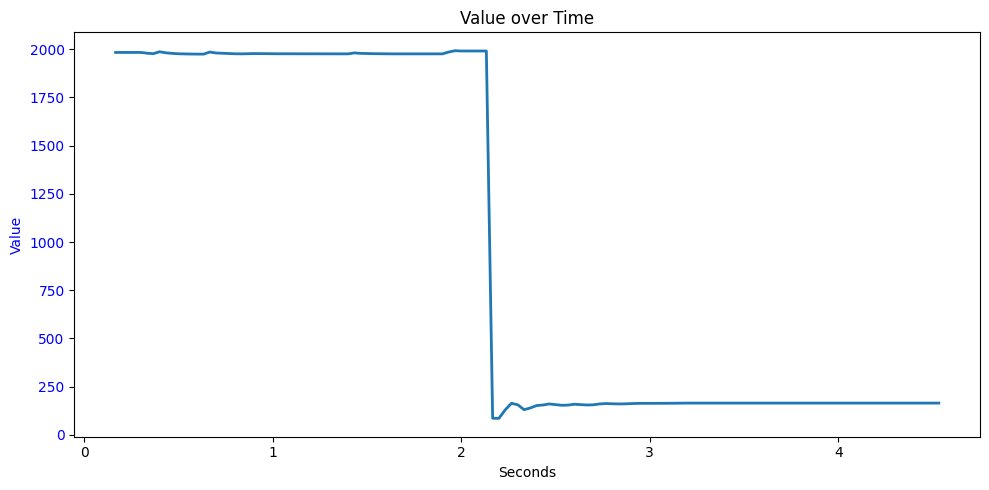

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("value_by_frame.csv")

df_f = df.copy()

# Plot filtered data
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(df_f["seconds"], df_f["value"], label="Value", linewidth=2)
ax1.set_xlabel("Seconds")
ax1.set_ylabel("Value", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

plt.title("Value over Time")
plt.tight_layout()
plt.show()


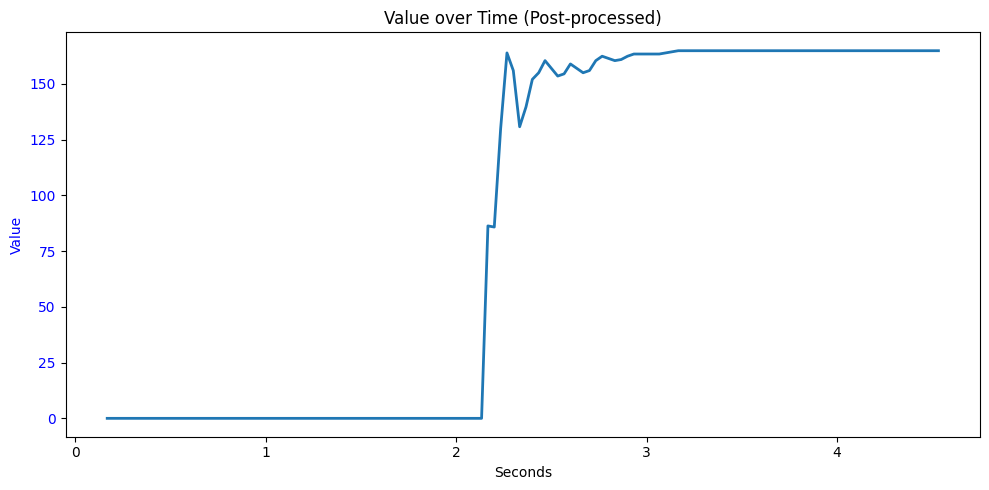

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("value_by_frame.csv")

# Ensure 'value' is numeric, turn bad parses into NaN
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# Remove rows where 'value' is missing
df = df.dropna(subset=["value"]).reset_index(drop=True)

df_f = df.copy()


initial_threshold = 200  # any initial value above threshold is treated as noise

# Make early values zero until the first "reasonable" one appears
for i in range(len(df_f)):
    if df_f.loc[i, "value"] > initial_threshold:
        df_f.loc[i, "value"] = 0
    else:
        break   # stop once we see a valid low value

# Plot filtered data
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(df_f["seconds"], df_f["value"], label="Value", linewidth=2)
ax1.set_xlabel("Seconds")
ax1.set_ylabel("Value", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

plt.title("Value over Time (Post-processed)")
plt.tight_layout()
plt.show()


In [41]:
df

,frame,seconds,angle_deg,value
0,0,0.000000,NaN,NaN
1,1,0.033333,NaN,NaN
2,2,0.066667,NaN,NaN
3,3,0.100000,NaN,NaN
4,4,0.133333,-92.20,NaN
...,...,...,...,...
132,132,4.400000,-63.31,164.859286
133,133,4.433333,-63.31,164.859286
134,134,4.466667,-63.31,164.859286
135,135,4.500000,-63.31,164.859286


In [ ]:
# FOR FISHING SCALES (DOUBLE)

import cv2
import numpy as np
from collections import deque, Counter
import easyocr
import csv
import math
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
VALUE_SCALE  = 1.0
VALUE_OFFSET = 0.0

# =========================
# CSV Recorder
# =========================
class ValueRecorder:
    def __init__(self, csv_path="value_by_frame.csv"):
        self.csv_path = csv_path
        self.rows = []  

    def add_single(self, frame, seconds, angle_deg, value):
        self.rows.append({
            'frame': frame,
            'seconds': seconds if seconds is not None else '',
            'angle_deg': angle_deg if angle_deg is not None else '',
            'value': value if value is not None else ''
        })

    def add_dual(self, frame, seconds, angle_deg, outer, inner):
        self.rows.append({
            'frame': frame,
            'seconds': seconds if seconds is not None else '',
            'angle_deg': angle_deg if angle_deg is not None else '',
            'outer': outer if outer is not None else '',
            'inner': inner if inner is not None else ''
        })

    def save(self):
        if not self.rows:
            return
        keys = set()
        for r in self.rows:
            keys.update(r.keys())
        ordered = []
        for k in ['frame', 'seconds']:
            if k in keys:
                ordered.append(k)
        for k in sorted(keys):
            if k not in ordered:
                ordered.append(k)

        with open(self.csv_path, 'w', newline='') as f:
            w = csv.DictWriter(f, fieldnames=ordered)
            w.writeheader()
            w.writerows(self.rows)
        print(f"[LOG] wrote {len(self.rows)} rows to {self.csv_path}")

# =========================
# Basic value/outlier filter
# =========================
class BasicValueFilter:
    """
    Rejects values that are outside [vmin, vmax] or that jump more than max_jump
    from the last accepted value. If hold_last=True, returns the last good value
    on rejection; otherwise returns None.
    """
    def __init__(self, vmin=None, vmax=None, max_jump=None, hold_last=True):
        self.vmin = vmin
        self.vmax = vmax
        self.max_jump = max_jump
        self.hold_last = hold_last
        self.prev = None  # last accepted value

    def __call__(self, v):
        # Reject NaNs / None
        if v is None or (isinstance(v, float) and (v != v)):
            return self.prev if self.hold_last else None

        # Range check
        if (self.vmin is not None and v < self.vmin) or (self.vmax is not None and v > self.vmax):
            return self.prev if self.hold_last else None

        # Step (jump) check
        if self.prev is not None and self.max_jump is not None:
            if abs(v - self.prev) > self.max_jump:
                return self.prev if self.hold_last else None

        # Accept
        self.prev = v
        return v

# =========================
# Circle Tracking
# =========================
class CircleMode:
    def __init__(self, maxlen=30, bin_size=3, min_samples=5,
                 max_center_diff=20, max_radius_diff=15):
        self.buffer = deque(maxlen=maxlen)
        self.bin_size = float(bin_size)
        self.min_samples = min_samples
        self.max_center_diff = max_center_diff
        self.max_radius_diff = max_radius_diff
        self.last = None

    def accept_circle(self, circle):
        if self.last is None:
            return True
        x, y, r = circle
        lx, ly, lr = self.last
        if abs(x - lx) > self.max_center_diff or abs(y - ly) > self.max_center_diff:
            return False
        if abs(r - lr) > self.max_radius_diff:
            return False
        return True

    def binned_mode(self, arr1d):
        bins = np.rint(arr1d / self.bin_size).astype(int)
        bid, count = Counter(bins.tolist()).most_common(1)[0]
        return bid * self.bin_size, count

    def update_circle(self, detected_circle):
        if detected_circle is not None:
            circle = tuple(map(float, detected_circle))
            if self.accept_circle(circle):
                self.buffer.append(circle)
                self.last = circle

        if len(self.buffer) < self.min_samples:
            return None

        arr = np.array(self.buffer)
        mx, _ = self.binned_mode(arr[:, 0])
        my, _ = self.binned_mode(arr[:, 1])
        mr, _ = self.binned_mode(arr[:, 2])
        return (mx, my, mr)

# =========================
# OCR
# =========================
reader = easyocr.Reader(['en'], gpu=False)

def detect_digits_easyocr(image, reader, min_conf=0.6):
    result = reader.readtext(image, detail=1, paragraph=False)
    digits, allowlist = [], "0123456789"
    for (bbox, text, prob) in result:
        if prob < min_conf:
            continue
        cleaned = ''.join(ch for ch in text if ch in allowlist)
        if cleaned == '':
            continue
        try:
            val_int = int(cleaned)
        except ValueError:
            continue
        xs, ys = zip(*bbox)
        cx_box, cy_box = int(sum(xs) / 4), int(sum(ys) / 4)
        digits.append({'center': (cx_box, cy_box),
                       'val': val_int, 'conf': float(prob)})
    return digits

def angle_deg_from_center(cx_box, cy_box, cx, cy):
    return float(np.degrees(np.arctan2(cy_box - cy, cx_box - cx)))

# =========================
# Unwrapping utilities
# =========================
def wrap180(deg):
    return (np.asarray(deg, dtype=float) + 180.0) % 360.0 - 180.0

def unwrap_sorted_from_phase(thetas_deg, phi_deg, direction=+1):
    thetas = np.asarray(thetas_deg, dtype=float)
    shifted = wrap180(thetas - phi_deg)
    order = np.argsort(shifted)
    u_sorted = direction * np.rad2deg(np.unwrap(np.deg2rad(shifted[order])))
    u = np.empty_like(u_sorted)
    u[order] = u_sorted
    return u, float(u_sorted.min()), float(u_sorted.max())

# =========================
# Phase-optimized calibration
# =========================
def fit_angle_to_value_phase_optimized(pairs,
                                       dedup_bin_deg=6.0,
                                       ransac_trim_frac=0.2,
                                       phi_step_coarse=5.0,
                                       phi_refine_halfwin=6.0,
                                       phi_step_refine=0.5, 
                                       value_max=None):
    if len(pairs) < 2:
        return None

    # Deduplicate by angle bins (keep highest-confidence per bin)
    by_bin = {}
    for p in pairs:
        b = int(np.rint(p['ang'] / dedup_bin_deg))
        if b not in by_bin or p.get('conf', 1.0) > by_bin[b].get('conf', 1.0):
            by_bin[b] = p
    P = list(by_bin.values())
    if len(P) < 2:
        return None

    thetas = np.array([p['ang'] for p in P], dtype=float)
    vals   = np.array([p['val'] for p in P], dtype=float)
    confs  = np.array([p.get('conf', 1.0) for p in P], dtype=float)
    W = np.diag(confs)

    def evaluate(phi_deg, direction):
        u, umin, umax = unwrap_sorted_from_phase(thetas, phi_deg, direction)
        A = np.vstack([u, np.ones_like(u)]).T
        a, b = np.linalg.lstsq(W @ A, W @ vals, rcond=None)[0]
        pred = a * u + b
        resid = vals - pred
        if 0.0 < ransac_trim_frac < 0.45 and len(vals) >= 5:
            kkeep = max(2, int(round((1.0 - ransac_trim_frac) * len(vals))))
            keep_idx = np.argsort(resid**2)[:kkeep]
            A_k = A[keep_idx]; vals_k = vals[keep_idx]; W_k = np.diag(confs[keep_idx])
            a, b = np.linalg.lstsq(W_k @ A_k, W_k @ vals_k, rcond=None)[0]
            pred = a * u + b
            resid = vals - pred
        ss_res = float(np.sum((resid) ** 2))
        ss_tot = float(np.sum((vals - vals.mean()) ** 2) + 1e-8)
        R2 = 1.0 - ss_res / ss_tot

        # uw = OnlineUnwrapper(phi_deg, direction, (umin, umax))
        def f_value(theta_deg):
            # u_live = uw.unwrap_one(theta_deg)
            # raw = a * u_live + b
            delta = direction * wrap180(theta_deg - phi_deg)
            raw = a * delta + b
            v = VALUE_SCALE * raw + VALUE_OFFSET

            if value_max is not None:
                if v > value_max:
                    v = v - value_max
                    
            return v

        return {
            'a': float(a), 'b': float(b), 'R2': float(R2),
            'dir': 'ccw' if direction > 0 else 'cw',
            'phi': float(phi_deg), 'span': (float(umin), float(umax)),
            'f': f_value
        }

    phis = np.arange(-180.0, 180.0, max(0.5, float(phi_step_coarse)))
    best = None
    for d in (+1, -1):
        for phi in phis:
            cand = evaluate(phi, d)
            if (best is None) or (cand['R2'] > best['R2']):
                best = cand

    phi0 = best['phi']; d0 = +1 if best['dir'] == 'ccw' else -1
    phis_ref = np.arange(phi0 - phi_refine_halfwin,
                         phi0 + phi_refine_halfwin + 1e-9,
                         max(0.1, float(phi_step_refine)))
    for phi in phis_ref:
        cand = evaluate(phi, d0)
        if cand['R2'] > best['R2']:
            best = cand

    print("[CAL] dir:", best['dir'], "phi:", f"{best['phi']:.2f}",
          "a:", f"{best['a']:.5f}", "b:", f"{best['b']:.3f}",
          "R2:", f"{best['R2']:.3f}", "span:", tuple(round(s,2) for s in best['span']))
    return best

# =========================
# Frame processing
# =========================
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)
    clahed = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(blurred)
    edges = cv2.Canny(clahed, 50, 150)

    # --- red mask (from your second script) ---
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    red1 = cv2.inRange(hsv, (0, 50, 50), (12, 255, 255))
    red2 = cv2.inRange(hsv, (168, 50, 50), (180, 255, 255))
    red_mask = cv2.medianBlur(cv2.bitwise_or(red1, red2), 5)

    return gray, blurred, edges, red_mask

def detect_circle(blurred):
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT,
                               dp=2, minDist=150, param1=120, param2=50,
                               minRadius=200, maxRadius=320) # Use min=200 and Max=320 for fishing scale videos
    if circles is None:
        return None
    x, y, r = max(np.round(circles[0, :]).astype(int), key=lambda c: c[2])
    return (x, y, r)

# =========================
# Dual-scale helpers
# =========================
def split_digits_into_rings(digits, cx, cy):
    """
    Split OCR digits into outer vs inner rings using 1D k-means on radius.
    Returns (outer_digits, inner_digits).
    """
    if not digits:
        return [], []
    radii = np.array([math.hypot(d['center'][0]-cx, d['center'][1]-cy) for d in digits], dtype=float)
    if len(radii) < 2:
        return digits, []  # not enough to split; treat as outer

    # Initialize two centers (quartiles) and iterate a few times
    c0 = np.percentile(radii, 25); c1 = np.percentile(radii, 75)
    centers = np.array([c0, c1], dtype=float)
    for _ in range(10):
        labels = np.argmin(np.abs(radii[:, None] - centers[None, :]), axis=1)
        new0 = radii[labels == 0].mean() if np.any(labels == 0) else centers[0]
        new1 = radii[labels == 1].mean() if np.any(labels == 1) else centers[1]
        if abs(new0 - centers[0]) < 1e-3 and abs(new1 - centers[1]) < 1e-3:
            break
        centers = np.array([new0, new1], dtype=float)

    # Identify which label is outer (larger radius)
    outer_lbl = int(np.argmax(centers))
    outer, inner = [], []
    for d, lbl in zip(digits, labels):
        (outer if lbl == outer_lbl else inner).append(d)
    return outer, inner

# =========================
# Needle tracker
# =========================
class NeedleTracker:
    def __init__(self,
                 window_deg=20.0,        # local search half-width
                 step_deg=1.0,           # coarse step
                 refine_half=3.0,        # refine window half-width
                 refine_step=0.2,        # refine step
                 hemi_margin=0.20,       # +20% stronger needed to consider opposite side
                 hemi_lock_frames=8,     # need N consecutive wins to actually switch
                 snr_gate=1.25,          # require at least this SNR between hemispheres
                 ema_alpha=0.45,         # 0..1; higher = less smoothing
                 darkness_w=0.35,        # weight for darkness term in score
                 inner_ratio=0.18,       # keep rays away from tick ring
                 outer_ratio=0.60,
                 red_w=2.0):             # weight for red-mask term
        self.prev = None
        self.window = float(window_deg)
        self.step = float(step_deg)
        self.refine_half = float(refine_half)
        self.refine_step = float(refine_step)
        self.hemi_margin = float(hemi_margin)
        self.hemi_lock_frames = int(hemi_lock_frames)
        self.snr_gate = float(snr_gate)
        self.alpha = float(ema_alpha)
        self.dark_w = float(darkness_w)
        self.inner_ratio = float(inner_ratio)
        self.outer_ratio = float(outer_ratio)
        self.red_w = float(red_w)

        self._hemi_win_count = 0  # consecutive wins for opposite hemisphere

    @staticmethod
    def _wrap180(a):
        return (a + 180.0) % 360.0 - 180.0

    @staticmethod
    def _angdiff(a, b):
        return abs((a - b + 180.0) % 360.0 - 180.0)

    def _ray_sums(self, gray, edges, red_mask, cx, cy, r, theta_deg):
        """Return (edge_sum, dark_sum, red_sum) along a ray at theta_deg."""
        h, w = gray.shape
        r1 = int(r * self.inner_ratio)
        r2 = int(r * self.outer_ratio)
        r2 = max(r2, r1 + 1)
        t = np.deg2rad(theta_deg)

        radii = np.linspace(r1 + 0.5, r2 - 0.5, num=max(1, r2 - r1 - 1))
        xs = cx + radii * np.cos(t)
        ys = cy + radii * np.sin(t)
        xi = np.clip(np.rint(xs).astype(int), 0, w - 1)
        yi = np.clip(np.rint(ys).astype(int), 0, h - 1)

        if red_mask is not None:
            red_ray = (red_mask[yi, xi] > 0).astype(np.uint8)
            edge_sum = float(np.sum(edges[yi, xi] * red_ray))  # edges restricted to red
            red_sum  = float(np.sum(red_ray))
        else:
            edge_sum = float(np.sum(edges[yi, xi]))
            red_sum  = 0.0

        dark_sum = float(np.sum(255 - gray[yi, xi]))  # if needle is dark
        return edge_sum, dark_sum, red_sum

    def _score(self, gray, edges, red_mask, cx, cy, r, theta_deg):
        """
        Anti-symmetric score: (ray at θ) - (ray at θ+180°),
        plus darkness and red-mask terms.
        """
        e1, d1, r1 = self._ray_sums(gray, edges, red_mask, cx, cy, r, theta_deg)
        e2, d2, r2 = self._ray_sums(gray, edges, red_mask, cx, cy, r, (theta_deg + 180.0) % 360.0)
        return (e1 - e2) + self.dark_w * (d1 - d2) + self.red_w * (r1 - r2)

    def _scan_peak(self, gray, edges, red_mask, cx, cy, r, start_deg, end_deg, step_deg):
        if end_deg < start_deg:
            start_deg, end_deg = end_deg, start_deg
        angles = np.arange(start_deg, end_deg + 1e-6, step_deg, dtype=float)
        scores = np.array(
            [self._score(gray, edges, red_mask, cx, cy, r, a) for a in angles],
            dtype=float
        )
        idx = int(np.argmax(scores))
        return float(angles[idx]), float(scores[idx])

    def _refine(self, gray, edges, red_mask, cx, cy, r, around_deg):
        a0 = around_deg
        a1, s1 = self._scan_peak(
            gray, edges, red_mask, cx, cy, r,
            a0 - self.refine_half, a0 + self.refine_half, self.refine_step
        )
        return a1, s1

    def measure(self, gray, edges, red_mask, cx, cy, r):
        # First frame: global scan
        if self.prev is None:
            a, s = self._scan_peak(gray, edges, red_mask, cx, cy, r, -180.0, 180.0, self.step)
            a, s = self._refine(gray, edges, red_mask, cx, cy, r, a)
            self.prev = a
            return a

        # Local around prev
        a1, s1 = self._scan_peak(
            gray, edges, red_mask, cx, cy, r,
            self.prev - self.window, self.prev + self.window, self.step
        )
        # Opposite hemisphere
        opp = self._wrap180(self.prev + 180.0)
        a2, s2 = self._scan_peak(
            gray, edges, red_mask, cx, cy, r,
            opp - self.window, opp + self.window, self.step
        )

        # Decide whether opposite hemisphere is truly better
        want_switch = (s2 > s1 * (1.0 + self.hemi_margin))
        snr = max(s1, s2) / (min(s1, s2) + 1e-6)
        if snr < self.snr_gate:
            want_switch = False

        # Consecutive wins required to actually switch hemisphere
        if want_switch:
            self._hemi_win_count += 1
        else:
            self._hemi_win_count = 0

        if self._hemi_win_count >= self.hemi_lock_frames:
            choice = a2
            self._hemi_win_count = 0
        else:
            choice = a1 if self._angdiff(a1, self.prev) <= self._angdiff(a2, self.prev) else a2

        # Refine and smooth (EMA on circle)
        best, _ = self._refine(gray, edges, red_mask, cx, cy, r, choice)
        diff = self._wrap180(best - self.prev)
        smoothed = self.prev + self.alpha * diff
        smoothed = self._wrap180(smoothed)

        self.prev = smoothed
        return smoothed

# =========================
# DRAW OVERLAY
# =========================
    
def draw_overlay(frame, sx, sy, sr, angle_deg, cal, gauge_mode,
                 value_single=None, value_outer=None, value_inner=None):
    # Circle + needle
    cv2.circle(frame, (sx, sy), sr, (255, 0, 0), 2)
    cv2.circle(frame, (sx, sy), 2, (0, 0, 255), 3)
    theta = np.deg2rad(angle_deg)
    r1, r2 = int(sr*0.1), int(sr*0.7)
    x1, y1 = int(sx + r1*np.cos(theta)), int(sy + r1*np.sin(theta))
    x2, y2 = int(sx + r2*np.cos(theta)), int(sy + r2*np.sin(theta))
    cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)

    # Value(s) — prefer provided (filtered) values; otherwise compute from cal
    y = 40
    if cal is not None:
        if gauge_mode == 'dual' and isinstance(cal, dict):
            if value_outer is None and cal.get('outer') is not None:
                value_outer = cal['outer']['f'](angle_deg)
            if value_inner is None and cal.get('inner') is not None:
                value_inner = cal['inner']['f'](angle_deg)

            if value_outer is not None:
                cv2.putText(frame, f"Outer: {value_outer:.2f}", (10, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                y += 28
            if value_inner is not None:
                cv2.putText(frame, f"Inner: {value_inner:.2f}", (10, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        else:
            if value_single is None:
                value_single = cal['f'](angle_deg)
            cv2.putText(frame, f"Value: {value_single:.2f}", (10, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)


# =========================
# Main
# =========================
def main(video_path,
         gauge_mode='single',     # 'single' or 'dual' (user specifies)
         csv_out="value_by_frame.csv",
         show_window=True,
         ocr_period=5,
         value_max_single=None,
         value_max_outer=None,
         value_max_inner=None,

         value_min=None, value_max=None, max_jump=None,             # for single-scale
         outer_min=None, outer_max=None, outer_max_jump=None,       # for dual outer
         inner_min=None, inner_max=None, inner_max_jump=None,       # for dual inner
         hold_last=True):                                           
    """
    If gauge_mode='single': one calibration across all digits found.
    If gauge_mode='dual':   split digits by radius into outer/inner rings and calibrate both.
    CSV will include:
      single -> frame, seconds, angle_deg, value
      dual   -> frame, seconds, angle_deg, outer, inner
    """

    if value_max is None:
        value_max = value_max_single
    if outer_max is None:
        outer_max = value_max_outer
    if inner_max is None:
        inner_max = value_max_inner

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("Error: Could not open video.")

    # FPS for seconds conversion;
    fps = cap.get(cv2.CAP_PROP_FPS)
    fps = fps if fps and fps > 1e-3 else None

    circle_mode = CircleMode()
    recorder = ValueRecorder(csv_out)

    # Instantiate basic filters
    if gauge_mode == 'dual':
        filt_outer = BasicValueFilter(vmin=outer_min, vmax=outer_max,
                                      max_jump=outer_max_jump, hold_last=hold_last)
        filt_inner = BasicValueFilter(vmin=inner_min, vmax=inner_max,
                                      max_jump=inner_max_jump, hold_last=hold_last)
    else:
        filt_single = BasicValueFilter(vmin=value_min, vmax=value_max,
                                       max_jump=max_jump, hold_last=hold_last)

    # Needle tracker (hemi lock + smoothing)
    needle_tracker = NeedleTracker(
        window_deg=18.0,
        step_deg=1.0,
        refine_half=3.0,
        refine_step=0.2,
        hemi_margin=0.25,
        ema_alpha=0.45,
        darkness_w=0.35,
        inner_ratio=0.5,
        outer_ratio=0.8
    )

    collected_all = []
    collected_outer, collected_inner = [], []
    cal = None  
    frame_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or read error.")
            break

        # seconds for this frame
        if fps is not None:
            seconds = frame_id / fps
        else:
            pos_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
            seconds = (pos_msec / 1000.0) if pos_msec else None

        gray, blurred, edges, red_mask = preprocess_frame(frame)
        stable = circle_mode.update_circle(detect_circle(blurred))

        angle_deg = None
        value_single = None
        value_outer = None
        value_inner = None

        if stable is not None:
            sx, sy, sr = map(int, stable)
            angle_deg = needle_tracker.measure(gray, edges, red_mask, sx, sy, sr)

            # OCR periodically while calibration is not ready
            if frame_id % ocr_period == 0 and (cal is None or (gauge_mode == 'dual' and (cal.get('outer') is None or cal.get('inner') is None))):
                digits = detect_digits_easyocr(blurred, reader)
                if digits:
                    if gauge_mode == 'dual':
                        outer_digits, inner_digits = split_digits_into_rings(digits, sx, sy)

                        def to_pairs(dlist):
                            pairs = []
                            for d in dlist:
                                cx_box, cy_box = d['center']
                                ang = angle_deg_from_center(cx_box, cy_box, sx, sy)
                                pairs.append({'ang': ang, 'val': d['val'], 'conf': d['conf']})
                            return pairs

                        collected_outer.extend(to_pairs(outer_digits))
                        collected_inner.extend(to_pairs(inner_digits))

                        if len(collected_outer) >= 3 and (cal is None or cal.get('outer') is None):
                            cal_out = fit_angle_to_value_phase_optimized(collected_outer, value_max=value_max_outer)
                        else:
                            cal_out = cal.get('outer') if isinstance(cal, dict) else None

                        if len(collected_inner) >= 3 and (cal is None or cal.get('inner') is None):
                            cal_in = fit_angle_to_value_phase_optimized(collected_inner, value_max=value_max_inner)
                        else:
                            cal_in = cal.get('inner') if isinstance(cal, dict) else None

                        cal = {'outer': cal_out, 'inner': cal_in}

                    else:  # single scale
                        for d in digits:
                            cx_box, cy_box = d['center']
                            ang = angle_deg_from_center(cx_box, cy_box, sx, sy)
                            collected_all.append({'ang': ang, 'val': d['val'], 'conf': d['conf']})
                        if len(collected_all) >= 3 and cal is None:
                            cal = fit_angle_to_value_phase_optimized(collected_all, value_max=value_max_single)

            # Compute value(s) and pass through filters
            if cal is not None:
                if gauge_mode == 'dual' and isinstance(cal, dict):
                    if cal.get('outer') is not None:
                        value_outer_raw = cal['outer']['f'](angle_deg)
                        value_outer = filt_outer(value_outer_raw)
                    if cal.get('inner') is not None:
                        value_inner_raw = cal['inner']['f'](angle_deg)
                        value_inner = filt_inner(value_inner_raw)
                else:
                    value_single_raw = cal['f'](angle_deg)
                    value_single = filt_single(value_single_raw)

            # Draw overlay (use filtered values so display matches CSV)
            if show_window and stable is not None:
                draw_overlay(frame, sx, sy, sr, angle_deg, cal, gauge_mode,
                             value_single=value_single, value_outer=value_outer, value_inner=value_inner)

        # Log per frame
        if gauge_mode == 'dual':
            recorder.add_dual(frame_id, seconds, angle_deg, value_outer, value_inner)
        else:
            recorder.add_single(frame_id, seconds, angle_deg, value_single)

        if show_window:
            cv2.imshow("Frame", frame if stable is not None else gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        frame_id += 1

    cap.release()
    recorder.save()
    if show_window:
        cv2.destroyAllWindows()
        cv2.waitKey(1)

# =========================
# Run 
# =========================
if __name__ == "__main__":
    gauge_mode = 'dual' # 'single' or 'dual'

    video_path = "../Video/doub2.mov"
    csv_path = "value_by_frame.csv"

    main(video_path, gauge_mode=gauge_mode, csv_out=csv_path, show_window=True, ocr_period=5, value_max_outer=75, value_max_inner=33)

Using CPU. Note: This module is much faster with a GPU.


[CAL] dir: ccw phi: 120.00 a: 0.20673 b: 43.739 R2: 0.950 span: (-158.77, 103.7)
[CAL] dir: ccw phi: 80.00 a: 0.09405 b: 16.062 R2: -0.052 span: (-116.12, 174.18)
End of video or read error.
[LOG] wrote 221 rows to value_by_frame.csv


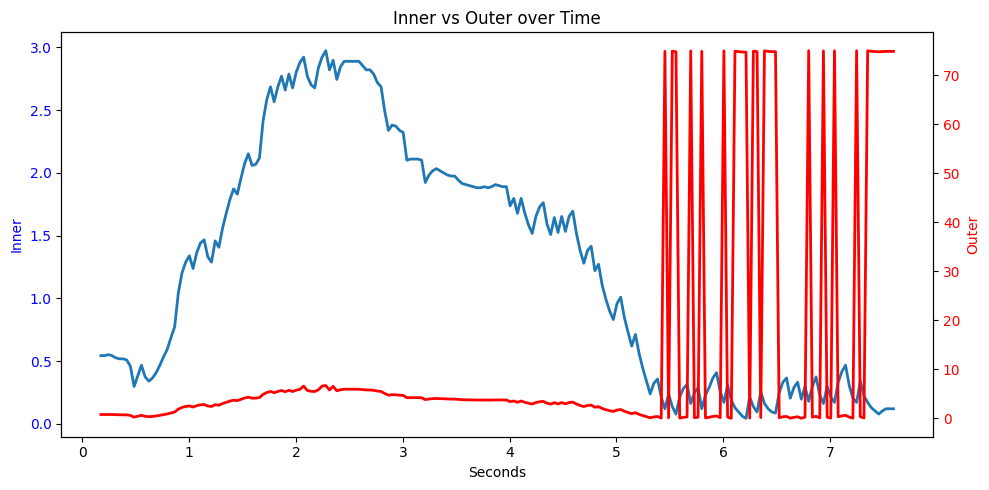

In [59]:
# PLOTTING FOR DOUBLE SCALE
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("value_by_frame.csv")

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(10,5))

# Left axis → inner
ax1.plot(df["seconds"], df["inner"], label="Inner", linewidth=2)
ax1.set_xlabel("Seconds")
ax1.set_ylabel("Inner", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Right axis → outer
ax2 = ax1.twinx()
ax2.plot(df["seconds"], df["outer"], label="Outer", color="red", linewidth=2)
ax2.set_ylabel("Outer", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Inner vs Outer over Time")
plt.tight_layout()
plt.show()


/var/folders/hd/rjkgpqd15sb8fjpp7d76twq80000gn/T/ipykernel_40951/1029608508.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["outer_smooth"] = df["outer_smooth"].fillna(method="bfill").fillna(method="ffill")


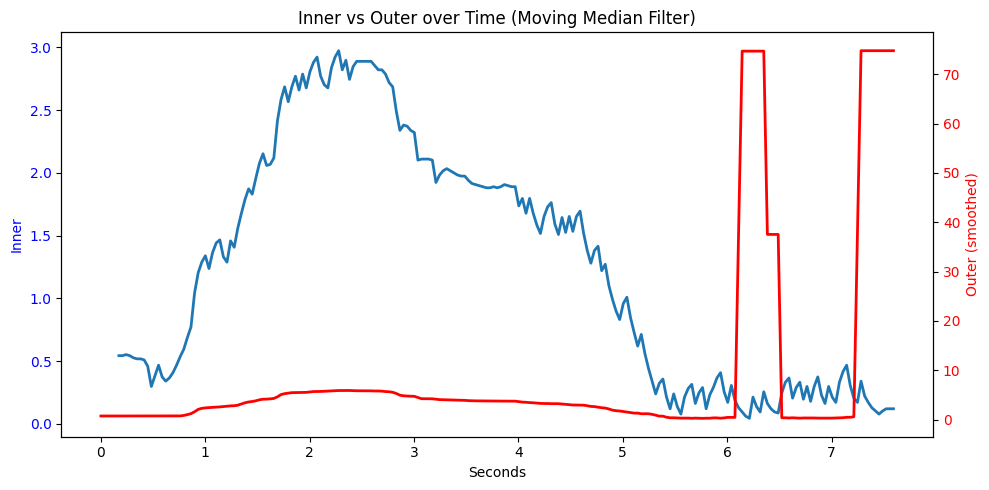

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("value_by_frame.csv")

# ---------------------------
# Moving Median Smoothing
# ---------------------------
# window=7 is a good default (adjust if needed)
df["outer_smooth"] = df["outer"].rolling(window=20, center=True).median()

# If the beginning/end produce NaN because of the window,
# you can optionally fill them by forward/backward fill:
df["outer_smooth"] = df["outer_smooth"].fillna(method="bfill").fillna(method="ffill")

# ---------------------------
# Plotting
# ---------------------------
fig, ax1 = plt.subplots(figsize=(10,5))

# Left axis → inner
ax1.plot(df["seconds"], df["inner"], label="Inner", linewidth=2)
ax1.set_xlabel("Seconds")
ax1.set_ylabel("Inner", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Right axis → smoothed outer
ax2 = ax1.twinx()
ax2.plot(df["seconds"], df["outer_smooth"], label="Outer (Median Smooth)", color="red", linewidth=2)
ax2.set_ylabel("Outer (smoothed)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Inner vs Outer over Time (Moving Median Filter)")
plt.tight_layout()
plt.show()

